In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpngw import write_apng
from IPython.display import Image
from pendulum import *
import mujoco
from lqr import *


  0%|          | 0/100 [00:00<?, ?it/s]

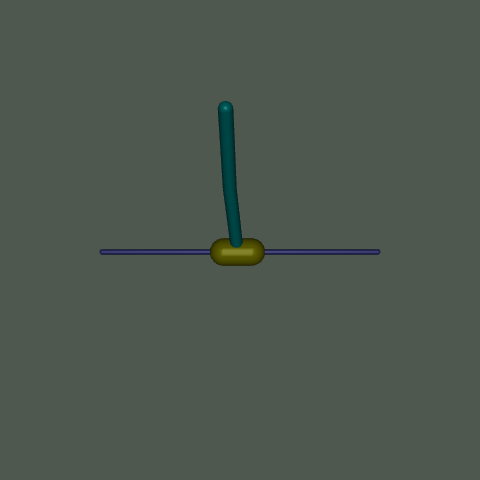

In [14]:
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()

frames = []  # frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")

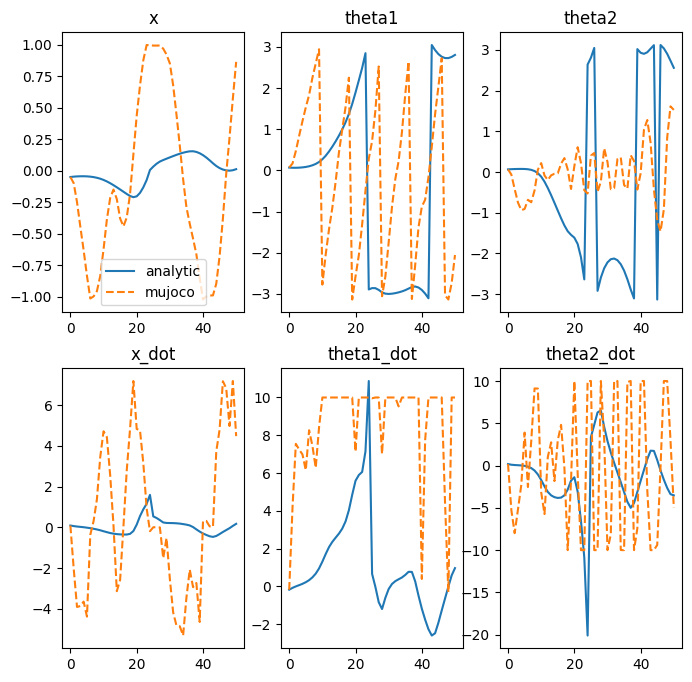

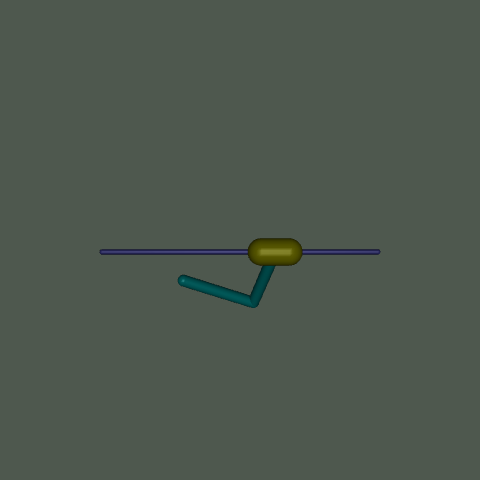

In [15]:
frames = []  # frames to create animated png
frames.append(env.render())
## Let's test to see if your analytic dynamics matches the simulator

# first let's generate a random control sequence
T = 50
#T=4
control_sequence = np.random.randn(T, 1)
#control_sequence = torch.zeros((T, 1))
#start_state = torch.tensor([1, 0.25, 0, 0])

# We use the simulator to simulate a trajectory
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state, _ = env.reset()
#env.reset(start_state)

states_mujoco = np.zeros((T+1, 8))
states_mujoco[0] = start_state[:8]

for t in range(T):
    #m = np.zeros((3,3))
    #mujoco.mj_fullM(env.model, m, env.data.qM)
    #print("mujoco", m)
    #print("mujoco", env.data.qpos)
    #print("mujoco", env.data.qfrc_bias)
    full_states_mujoco, _, _, _, _ = env.step(control_sequence[t])
    states_mujoco[t+1] = full_states_mujoco[:8]
    img = env.render()
    frames.append(img)

# Now we will use your analytic dynamics to simulate a trajectory
# Need an extra 1 which is the batch dimension (T x B x 4)
states_analytic = torch.zeros((T+1, 1, 6))
states_analytic[0] = change_of_coords(start_state)
for t in range(T):
    #print("analytic", states_analytic[t])
    states_analytic[t + 1] = dynamics_analytic(
        states_analytic[t], torch.from_numpy(control_sequence[t]))

# convert back to numpy for plotting
states_analytic = states_analytic.reshape(T+1, 6)

# convert mujoco states to analytic states
states_mujoco_transformed = T_change_of_coords(states_mujoco)

# Plot and compare - They should be indistinguishable
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

axes[0][0].plot(states_analytic[:, 0], label='analytic')
axes[0][0].plot(states_mujoco_transformed[:, 0], '--', label='mujoco')
axes[0][0].title.set_text('x')

axes[0][1].plot(states_analytic[:, 1])
axes[0][1].plot(states_mujoco_transformed[:, 1], '--')
axes[0][1].title.set_text('theta1')

axes[0][2].plot(states_analytic[:, 2])
axes[0][2].plot(states_mujoco_transformed[:, 2], '--')
axes[0][2].title.set_text('theta2')

axes[1][0].plot(states_analytic[:, 3])
axes[1][0].plot(states_mujoco_transformed[:, 3], '--')
axes[1][0].title.set_text('x_dot')

axes[1][1].plot(states_analytic[:, 4])
axes[1][1].plot(states_mujoco_transformed[:, 4], '--')
axes[1][1].title.set_text('theta1_dot')

axes[1][2].plot(states_analytic[:, 5])
axes[1][2].plot(states_mujoco_transformed[:, 5], '--')
axes[1][2].title.set_text('theta2_dot')

axes[0][0].legend()
plt.show()

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")


In [16]:
# Get properties of the pendulum

import mujoco
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()
m = env.model.body_mass
l = env.model.geom_size
lcm = env.model.body_ipos
print(m)
print(l)
print(lcm)

print(mujoco.mj_name2id(env.model, 1, 'cart'))
print(mujoco.mj_name2id(env.model, 1, 'pole'))
print(mujoco.mj_name2id(env.model, 1, 'pole2'))

print(env.model.dof_damping)
print(env.model.opt.timestep)
print(env.model.opt.gravity)

I = env.model.body_inertia
print(I)


[ 0.         10.47197551  4.19873858  4.19873858]
[[4.0e+01 4.0e+01 4.0e+01]
 [2.0e-02 1.0e+00 0.0e+00]
 [1.0e-01 1.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.3]
 [0.  0.  0.3]]
1
2
3
[0.05 0.05 0.05]
0.01
[ 1.00e-05  0.00e+00 -9.81e+00]
[[0.         0.         0.        ]
 [0.1267109  0.1267109  0.04817109]
 [0.15497067 0.15497067 0.00417393]
 [0.15497067 0.15497067 0.00417393]]


In [3]:
# perform rollouts to obtain the nominal state and control trajectories
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state,_ = env.reset()
T = 50

# start the nominal state trajectory at the initial state from env
init_state = start_state[:8].reshape(8,1)
xs_nom, us_nom = rollout_dynamics(T, init_state)
# print(f'{xs_nom.shape=}')
# print(f'{us_nom.shape=}')

# verify that we can linearize about a point 
# A_autograd, B_autograd = linearize_pytorch(np.zeros((6)), np.zeros((1)))
A_autograd, B_autograd = linearize_pytorch(torch.zeros((6)), torch.zeros((1)))

print('Autograd linearizations are ')
print(A_autograd.shape)
print(B_autograd.shape)     

Autograd linearizations are 
torch.Size([6, 6])
torch.Size([6, 1])


c:\Users\mstpd\Documents\Michigan\Classes\ROB_498\DoublePendulum\pendulum.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor([x, th1, th2, xdot, th1dot, th2dot])


In [8]:
## define the cost functions

# set the desired state (xstar), should be the goal state
xstar = torch.zeros((6,))
# set the Q and R matrices
# TODO: tune the Q, R amd Qf matrices
Q = torch.eye(6)
R = torch.tensor([1])
Qf = 1000 * torch.eye(6)

# test of the running cost function
# curr_x = xs_nom[0, :].reshape(6,)
# curr_u = us_nom[0, :].reshape(1,)
# running_cost = running_cost_func(curr_x, curr_u, xstar, Q, R)
# print(running_cost)

# # test of the terminal cost fuction
# final_x = xs_nom[-1, :].reshape(6,)
# term_cost = term_cost_func(final_x, xstar, Qf)
# print(term_cost)

# compute the total cost for the nominal trajectory
total_cost = total_cost_func(xs_nom, us_nom, xstar, Q, R, Qf)
print(total_cost)

tensor([50046.8789])


In [ ]:
# set up the functions for computing the derivatives of the cost functions

In [ ]:
# set up the functions for computing the derivatives of the value function

In [10]:
# set up the backward pass function (recursively apply the belman equation)
# proceed backwards in time through the nominal trajectory
def backward_pass(xs_nom, us_nom):

    N = xs_nom.shape[0]

    # set the initial state and control values to the nominal trajectories
    # set the initial p (jacobian of cost function) and P (hessian of the cost fuction) values

    # initialize the variable for storing the gains k and K

    # for each value in the nominal trajectory
    for t in reversed(range(N-1)):
        # print(t)

        # compute the first and second derivative of the lienarized dynamics (lx, lu, etc)

        # compute the first and second derivatives of the value function (Vx')

        # compute qx, qu, Q (from the previous iteration, pn+1)

        # compute the gains k and K

        # use the new k and K to compute p and P (plug back into the cost to go function)

        # append the gains to thew list

# test the backward pass
backward_pass(xs_nom, us_nom)



49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [7]:
## perform iLQR
# run loop until convergence is reached
num_iterations = 20
while i < num_iterations:
    # perform the backwards pass

    # perform the forward pass

    i += 1

NameError: name 'i' is not defined